In [547]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, LinearConstraint
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [548]:
# AAPL 데이터 불러오기

AAPL_data = pd.read_csv('data/AAPL.csv')
AAPL_data = AAPL_data.set_index('Date')

#인덱스를 datetime으로 변경
AAPL_data.index = pd.to_datetime(AAPL_data.index)
AAPL_data['log_price_return'] = np.log(AAPL_data['Adj Close']).diff(1)
returns = AAPL_data['log_price_return'].dropna()

In [549]:
def calculate_volatility(returns):
    squared_log_price_return = (returns ** 2).dropna()
    volatility = squared_log_price_return.rolling(window=5).sum() / 5.0

    return volatility.dropna()

In [550]:
#sample variance
var = np.std(returns) ** 2

In [551]:
from garch.garch_mle import garch_mle

In [552]:
import datetime as dt
split_date= dt.datetime(2011,12,2)

index = returns.index
end_loc = np.where(index > split_date)[0].min()
train_data = returns.iloc[:end_loc,]

bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]
#조건 alpha + beta < 1
LC = LinearConstraint([[0,1,1]], lb=0, ub=1)

# DE 알고리즘을 사용한 파라미터 추정
result = differential_evolution(garch_mle, bounds=bounds, args=(train_data,), constraints=LC,
                                strategy='best1bin', maxiter=30, popsize=20, tol=1e-4, mutation=(0.1, 1),
                                recombination=0.7)

print("Optimized GARCH(1,1) Parameters:")
print(result.x)

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimized GARCH(1,1) Parameters:
[1.20265327e-05 1.06253422e-01 8.90614494e-01]


In [553]:
realized_vol = calculate_volatility(returns)

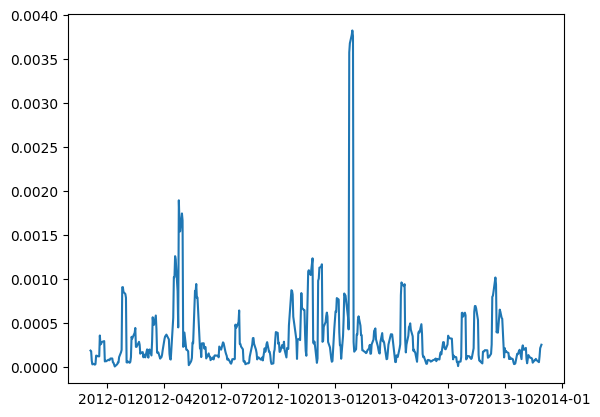

In [554]:
import datetime as dt

split_date= dt.datetime(2011,12,2)

index = returns.index
end_loc = np.where(index >= split_date)[0].min()

test_data = realized_vol.iloc[end_loc-4:,]
plt.plot(test_data.iloc[1:,])

<Figure size 1000x600 with 0 Axes>

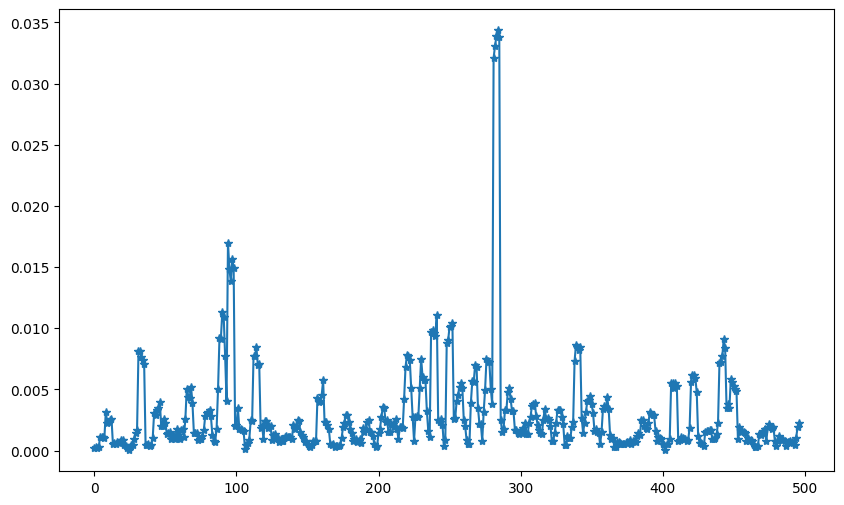

In [555]:
from sklearn.preprocessing import MinMaxScaler
plt.figure(figsize=(10,6))

#volatility 정규화
scaler = MinMaxScaler()
normalzied_volatility = scaler.fit_transform(realized_vol.values.reshape(-1,1))
plt.plot(normalzied_volatility[end_loc:], marker='*')

In [556]:
omega, alpha, beta = result.x
# omega, alpha, beta = [0.0016,0.32,0.67]

In [557]:
len(realized_vol.iloc[end_loc-4:,])

501

In [558]:
test_data = realized_vol.iloc[end_loc-4:,]
test_returns = returns.iloc[end_loc:]

forecasts = np.zeros(len(test_data))
for t in range(1, len(test_data)):
    forecasts[t] = (omega + alpha*test_returns[t-1]**2 + beta*test_data[t-1])

<Figure size 1000x600 with 0 Axes>

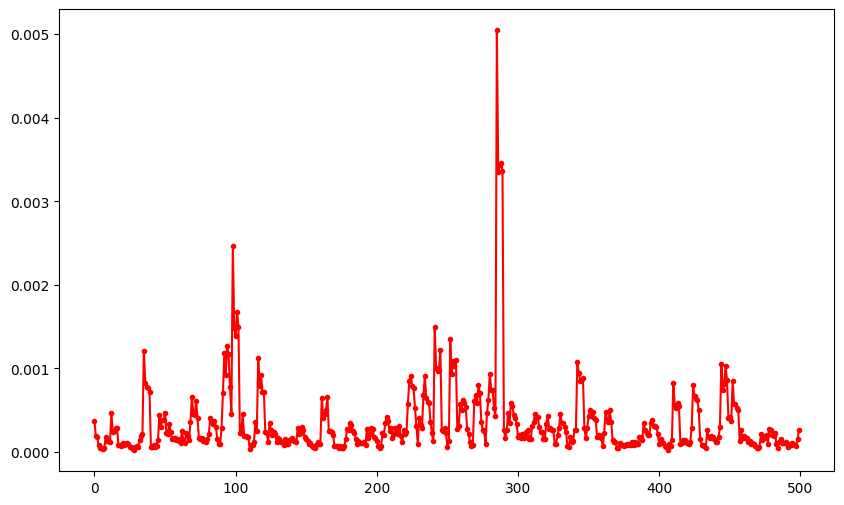

In [559]:
plt.figure(figsize=(10,6))
plt.plot(forecasts[1:], color='red', marker='o', markersize=3)

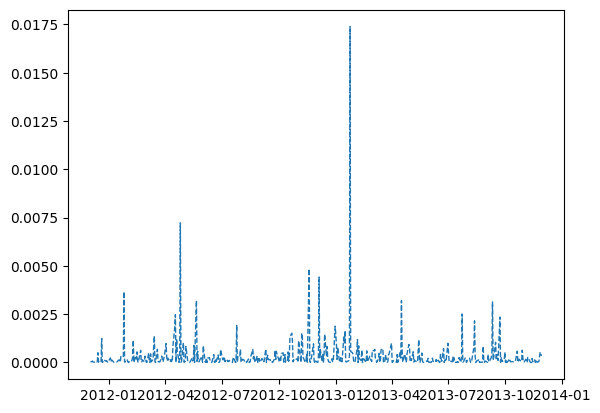

In [560]:
plt.plot((returns**2)[end_loc:], linestyle = '--', linewidth=1)

In [434]:
arr = np.concatenate((test_data,forecasts[1:]))

In [435]:
test_data

Date
2011-12-02    0.000404
2011-12-05    0.000188
2011-12-06    0.000182
2011-12-07    0.000073
2011-12-08    0.000032
                ...   
2013-11-22    0.000075
2013-11-25    0.000057
2013-11-26    0.000123
2013-11-27    0.000216
2013-11-29    0.000255
Name: log_price_return, Length: 501, dtype: float64